In [39]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn.functional as F

from nilearn.image import load_img
from nilearn.image.image import mean_img
from nilearn.plotting.img_plotting import plot_roi

from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import Shrinkage
from sklearn.pipeline import make_pipeline
from pyriemann.estimation import Covariances

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from dataloader import HaxbyDataset
from models import ExtractSegments, ccw, Encoder
from utils import show_scan_slices

In [40]:
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [Haxby datset](http://www.pymvpa.org/datadb/haxby2001.html)

During the experiment, the subjects were shown various images. Image categories are represented in labels, namely, each label corresponds to a certain category of images. For example, if images of various objects were used in the experiment, the labels may indicate certain objects.

Classes:
- bottle
- cat
- chair
- face
- house
- scissors
- - scrambled pix
- shoe

There are also rest periods indicated by rest.

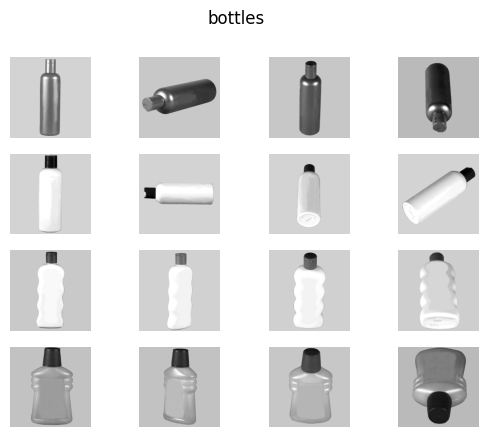

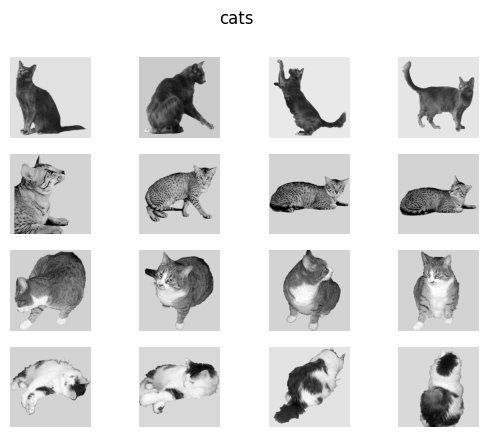

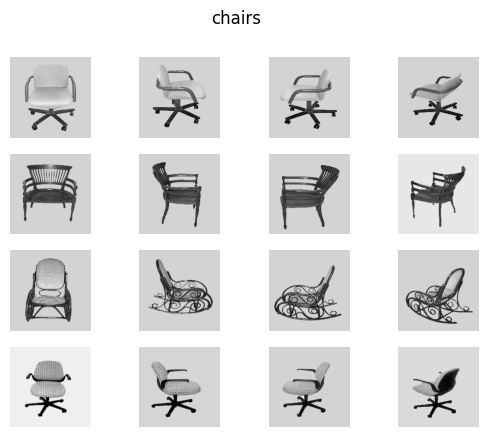

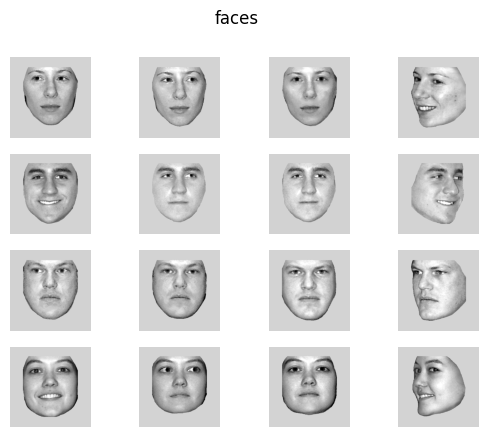

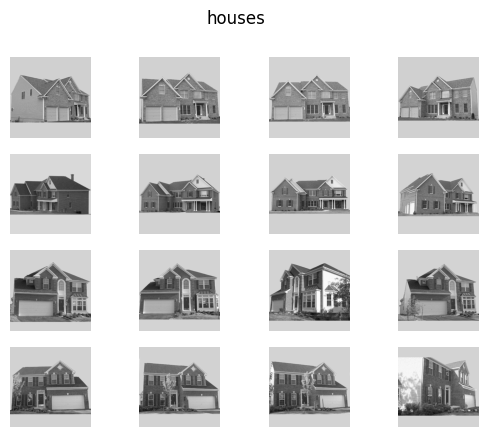

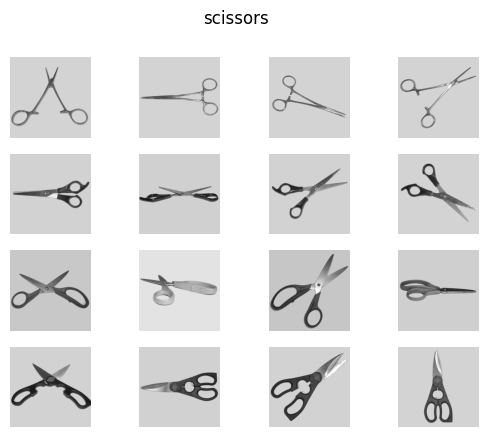

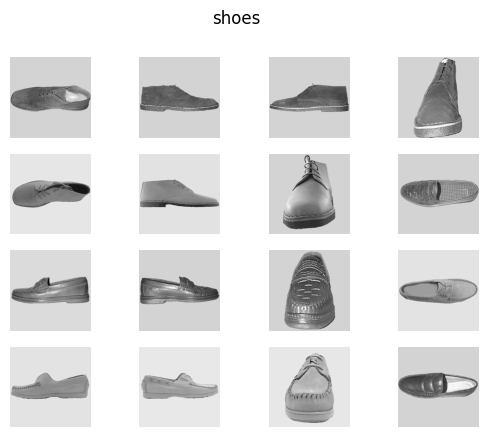

In [41]:
dataset = HaxbyDataset()

# Paths to dataset files
data_files = dataset.data_files

# Drawing examples of stimuli
dataset.plot_stimuli()

We will get the data of the first test subject

In [3]:
fmris, labels = dataset.get_sub_data(1)

NameError: name 'dataset' is not defined

#### Activity masks

In [6]:
vt_mask_filename = load_img(data_files.mask_vt[0])
func_filename = data_files.func[0]
mean_haxby = mean_img(func_filename)
vt_mask = vt_mask_filename.get_fdata().shape

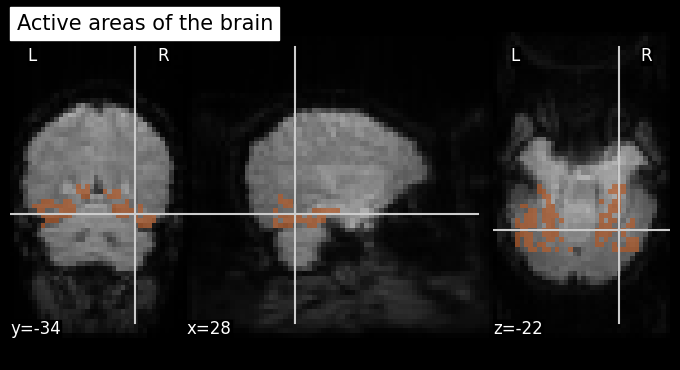

In [7]:
plot_roi(vt_mask_filename, bg_img=mean_haxby, title = 'Active areas of the brain', draw_cross=True, cmap='Paired')
plt.show()

### Data preparation
The data of the first subject is stored in fmris, labels variables, we divide the sequence into time series by classes.
Let's encode the classes as follows: 
- rest: 0
- bottle: 1
- cat: 2
- chair: 3
- face: 4
- house: 5
- scissors: 6
- scrambledpix: 7
- shoe: 8

Also, let's pay attention to the structure of the data, before the stimulus is shown and after the stimulus is shown, there are about 5 moments of rest time. The stimulus itself is demonstrated at exactly 9 points in time, so let's fix $\tau = 19$.

$\mu = 2.5$ Hz

In [6]:
class_dict = {'rest': 0, 'bottle': 1, 'cat': 2, 'chair': 3, 'face': 4, 'house': 5, 'scissors': 6, 'scrambledpix': 7, 'shoe': 8}

stimuli = np.array([class_dict[label] for label in labels['labels'].values])
fmris_transposed = fmris.transpose((3, 0, 1, 2))

In [7]:
# Segmentation of the time series by stimuli classes
X, s, y = ExtractSegments(fmris_transposed, stimuli, tau=19)
y=y-1

In total, 96 fMRI time series of length 19 were obtained, each class has 12 rows.

### Testing the Voxel Weighing Algorithm

In [8]:
def plot_ccw_results(X, s, mu, k_s, Delta_t, h, masked_brain=False):
    M, p_values = ccw(X, s, mu, k_s, Delta_t, h, masked_brain)
    show_scan_slices(X[0], [28, 20, 24], M, title='Mask by top h correlations')
    show_scan_slices(X[0], [28, 20, 24], p_values<0.05, title='Mask obtained from rejected hypotheses')
    print(f'The number of areas obtained by statistical analysis: {np.sum(p_values<0.05)}')

#### An example of applying the method over the entire time series of the subject:

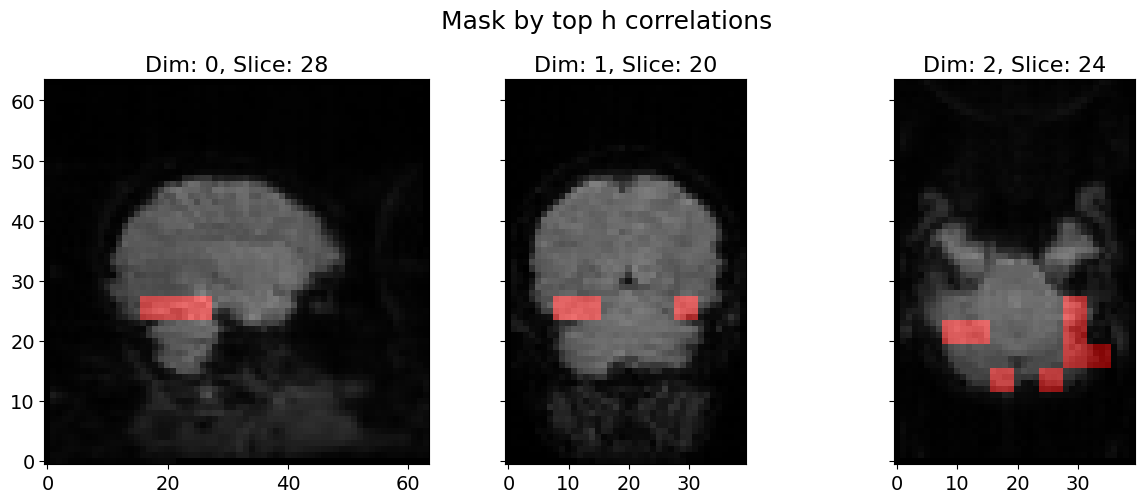

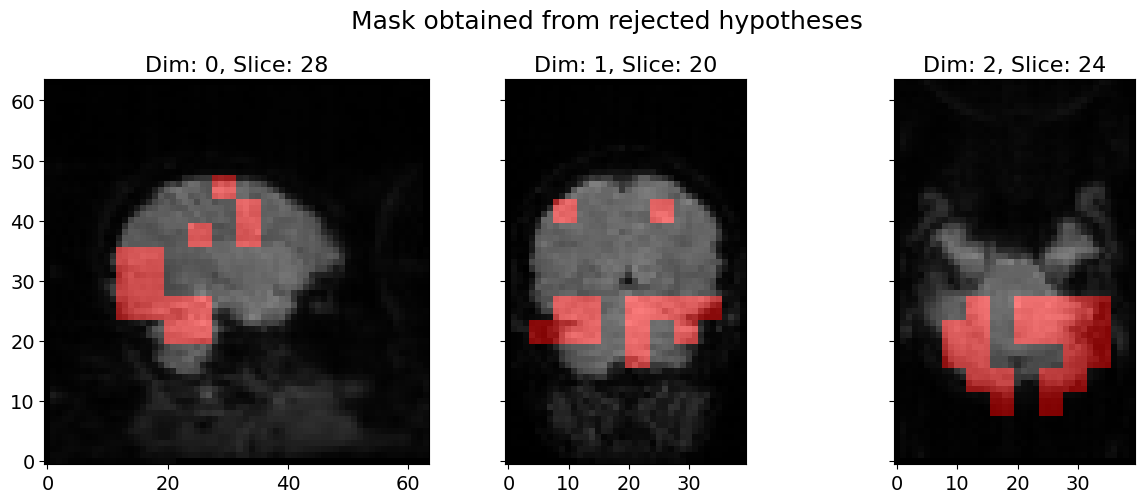

The number of areas obtained by statistical analysis: 5376


In [11]:
bin_stimuli = stimuli.copy()
bin_stimuli[bin_stimuli!=0]=1

plot_ccw_results(X=fmris_transposed, s=bin_stimuli, mu=2.5, k_s=4, Delta_t=0, h=10, masked_brain=False)

#### We apply the method on a small time series of fMRI, which corresponds to a certain stimulus:

##### 1) Cat

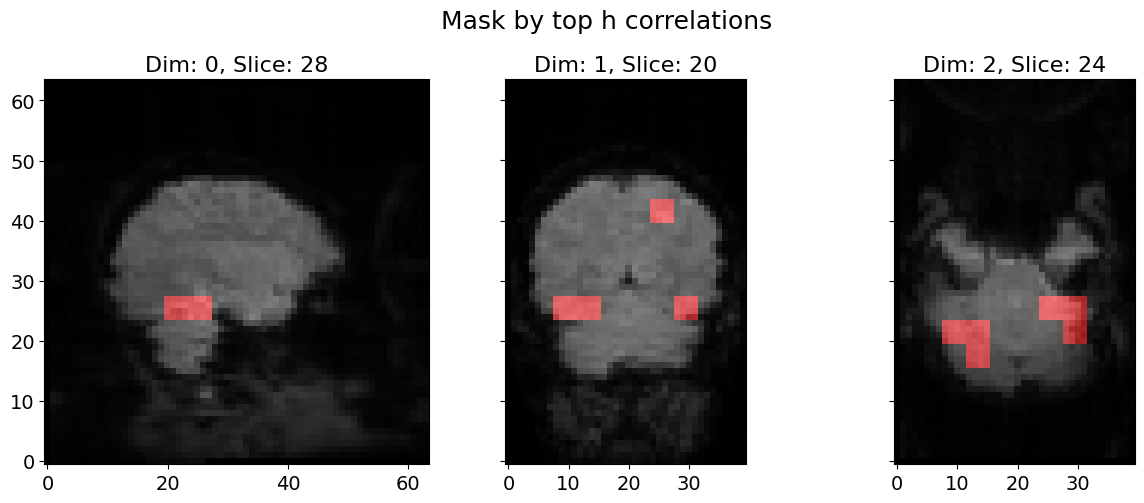

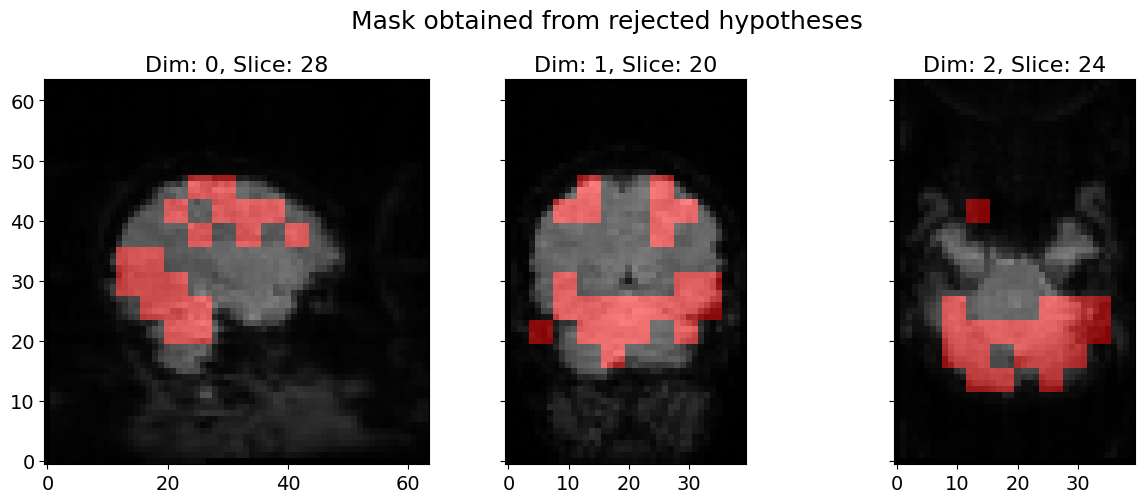

The number of areas obtained by statistical analysis: 7744


In [12]:
fMRI_cat = np.array(X[12]).astype('float64')
s_cat = s[12].astype('int')
s_cat[s_cat!=0]=1

plot_ccw_results(X=fMRI_cat, s=s_cat, mu=2.5, k_s=4, Delta_t=0, h=10, masked_brain=False)

#### 2) Bottle

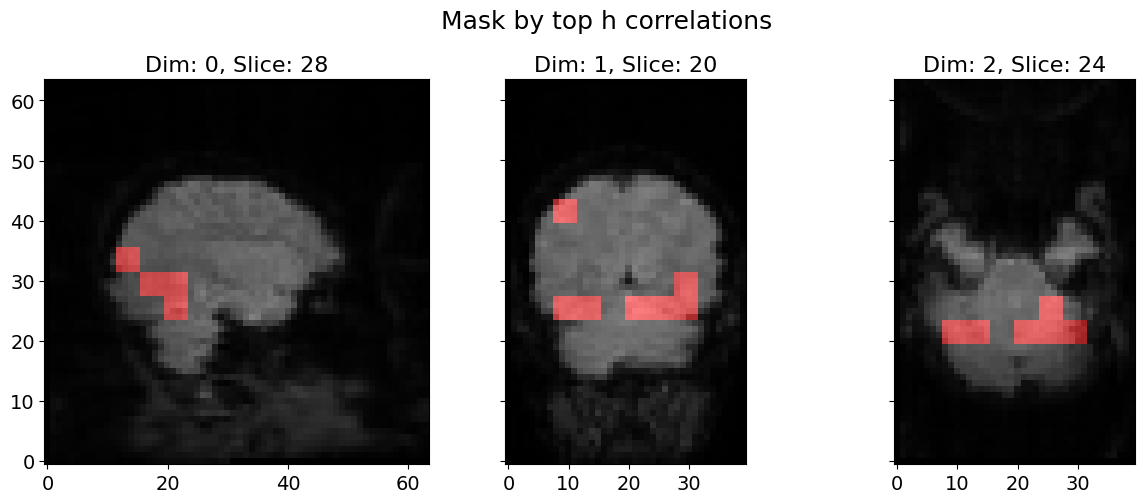

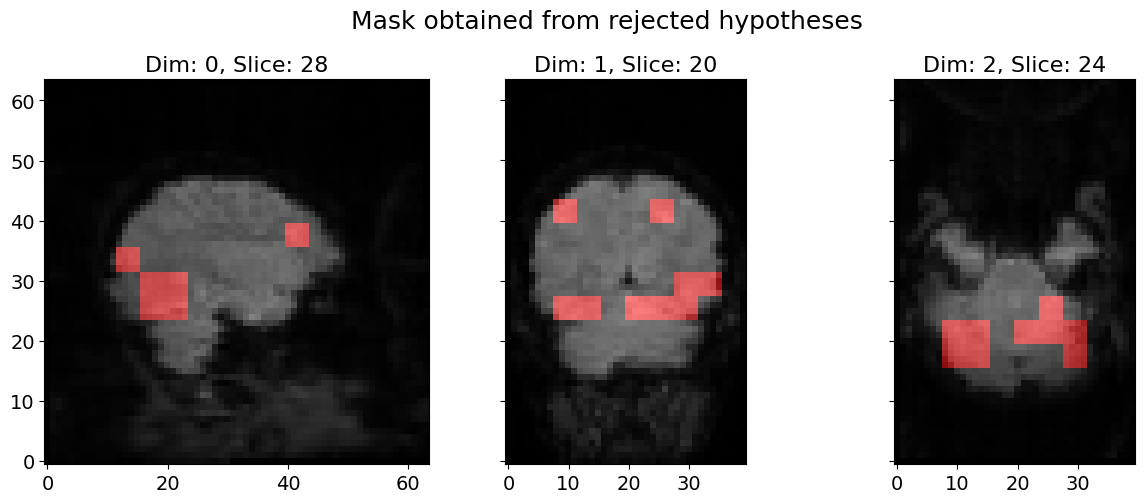

The number of areas obtained by statistical analysis: 1920


In [13]:
fMRI_bottle = X[0].astype('float64')
s_bottle = s[0].astype('int')
s_bottle[s_bottle!=0]=1

plot_ccw_results(X=fMRI_bottle, s=s_bottle, mu=2.5, k_s=4, Delta_t=0, h=15, masked_brain=False)

#### 3) Faces

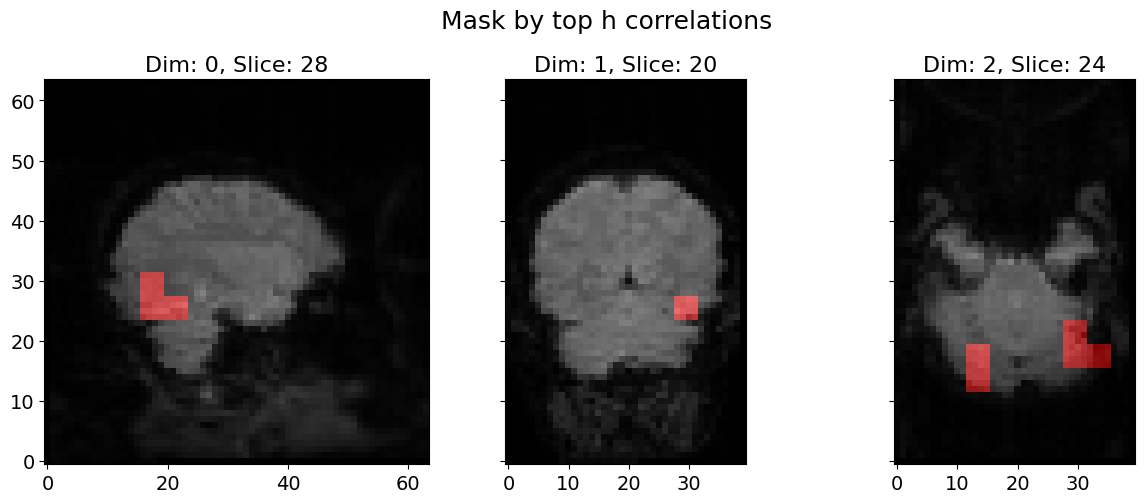

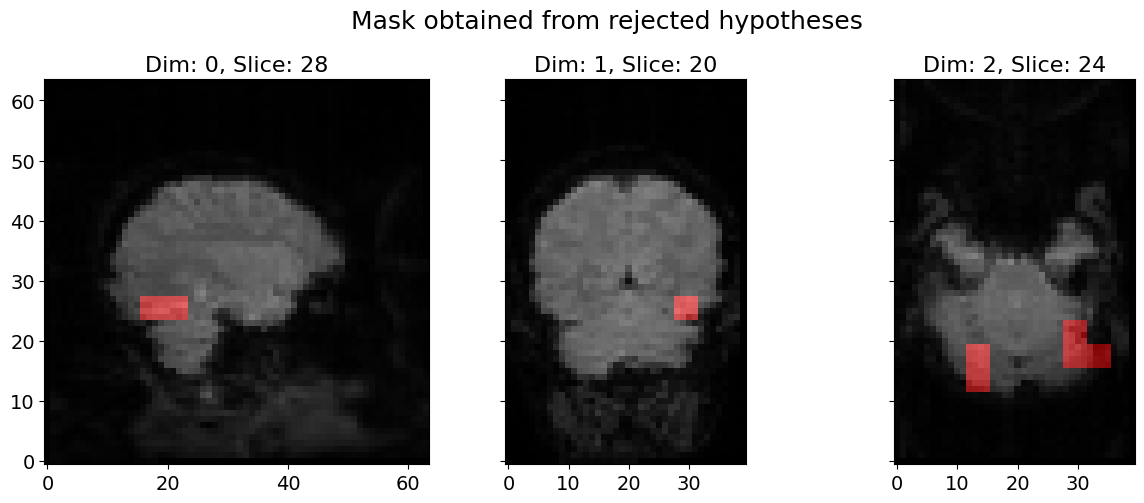

The number of areas obtained by statistical analysis: 512


In [14]:
fMRI_face = X[40].astype('float64')
s_face = s[40].astype('int')
s_face[s_face!=0]=1

plot_ccw_results(X=fMRI_face, s=s_face, mu=2.5, k_s=4, Delta_t=0, h=10, masked_brain=False)

#### Correctness
Experiment with noise, check that the selection of areas is not random, take a random set of ones and zeros as a stimulus vector:

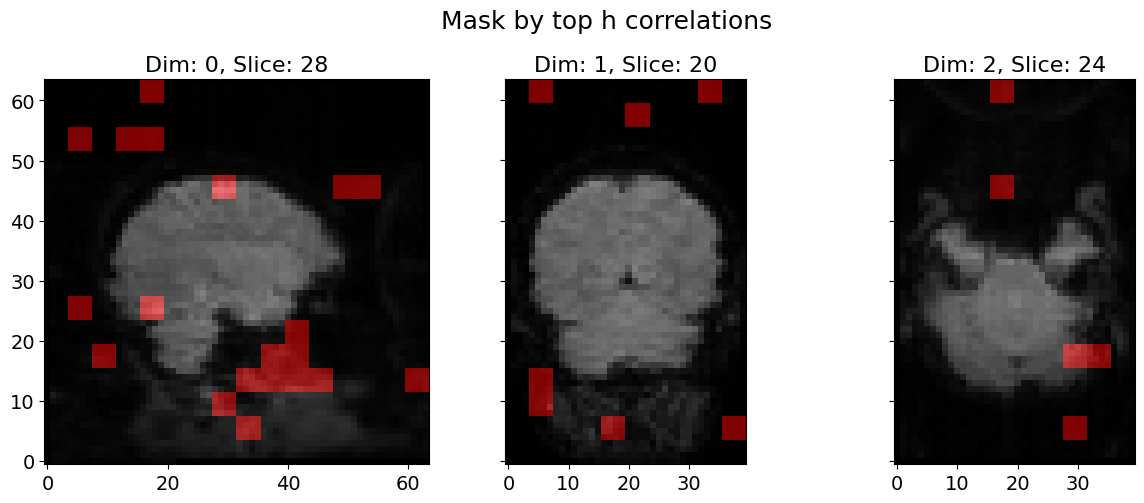

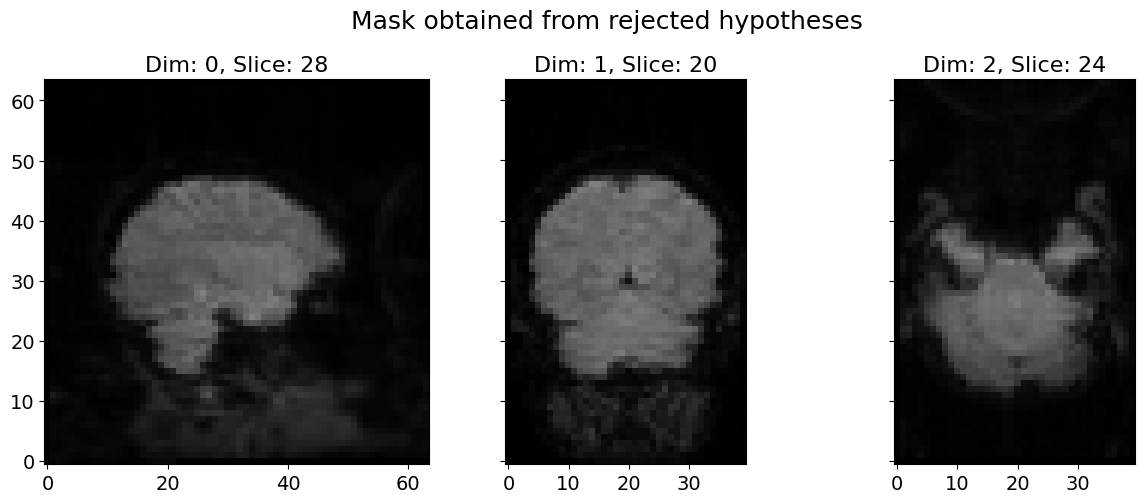

The number of areas obtained by statistical analysis: 0


In [15]:
np.random.seed(10)
rand_s = np.random.randint(0, 2, size=fmris_transposed.shape[0])

plot_ccw_results(X=fmris_transposed, s=rand_s, mu=2.5, k_s=4, Delta_t=0, h=100, masked_brain=False)

### Классификация сегментов временного ряда фМРТ

In [89]:
def get_results_for_sub(num, stat_test=True):
    dataset = HaxbyDataset()
    fmris, labels = dataset.get_sub_data(num)

    class_dict = {'rest': 0, 'bottle': 1, 'cat': 2, 'chair': 3, 'face': 4, 'house': 5, 'scissors': 6, 'scrambledpix': 7, 'shoe': 8}
    stimuli = np.array([class_dict[label] for label in labels['labels'].values])
    fmris_transposed = fmris.transpose((3, 0, 1, 2))

    X, s, y = ExtractSegments(fmris_transposed, stimuli, tau=19)
    y=y-1

    X = X.astype('float64')
    s = s.astype('int')
    X_train, X_test, s_train, _, y_train, y_test = train_test_split(X, s, y, test_size=0.20, random_state=42, stratify=y)
    clf = Encoder(mu=2.5, k_s=4, Delta_t=0.0, h=10, stat_test=stat_test)
    clf.fit(X_train, s_train, y_train)

    X_ptrain = clf.transform(X_train)
    X_ptest = clf.transform(X_test)

    # 1. Logistic Regression
    print("Logistic Regression")
    lr = LogisticRegression(C=1e2, class_weight='balanced', random_state=42)
    lr.fit(X_ptrain, y_train)
    lr_pred = lr.predict(X_ptest)
    macro_f1_logreg = f1_score(y_test, lr_pred, average='macro')
    micro_f1_logreg = f1_score(y_test, lr_pred, average='micro')
    acc_logreg = accuracy_score(y_test, lr_pred)
    print(f"Macro-average F1-Score: {macro_f1_logreg:.4f}")
    print(f"Micro-average F1-Score: {micro_f1_logreg:.4f}")
    print(f"Accuracy: {acc_logreg:.4f}\n")

    # 2. MLP
    print("MLP")
    clf = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=200, activation = 'logistic')
    clf.fit(X_ptrain, y_train)

    y_pred = clf.predict(X_ptest)
    macro_f1_mlp = f1_score(y_test, y_pred, average='macro')
    micro_f1_mlp = f1_score(y_test, y_pred, average='macro')
    acc_mlp = accuracy_score(y_test, y_pred)
    print(f"Macro-average F1-Score: {macro_f1_mlp:.4f}")
    print(f"Micro-average F1-Score: {micro_f1_mlp:.4f}")
    print(f"Accuracy: {acc_mlp:.4f}")

    return macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp


Пример работы:

In [90]:
seed=90
np.random.seed(seed)
torch.manual_seed(seed)
get_results_for_sub(1)

Logistic Regression
Macro-average F1-Score: 0.5188
Micro-average F1-Score: 0.5500
Accuracy: 0.5500

MLP
Macro-average F1-Score: 0.6405
Micro-average F1-Score: 0.6405
Accuracy: 0.6500


(0.51875, 0.55, 0.55, 0.6404761904761904, 0.6404761904761904, 0.65)

In [17]:
seed=2
np.random.seed(seed)
torch.manual_seed(seed)
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_results_for_sub(2)

Logistic Regression
Macro-average F1-Score: 0.5976
Micro-average F1-Score: 0.6500
Accuracy: 0.6500

MLP
Macro-average F1-Score: 0.6488
Micro-average F1-Score: 0.6488
Accuracy: 0.7000


In [67]:
seed=3
np.random.seed(seed)
torch.manual_seed(seed)
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_results_for_sub(3)

Logistic Regression
Macro-average F1-Score: 0.5976
Micro-average F1-Score: 0.6500
Accuracy: 0.6500

MLP
Macro-average F1-Score: 0.6104
Micro-average F1-Score: 0.6104
Accuracy: 0.6500


### Ablation 
1. Disable Tangent Space Mapping, use time series rectification.
2. We get a general activity mask for all time series from the training sample, then use Tangent Space Mapping.

In [33]:
def apply_cls_mask(X, M, k_s):
    # Expand the mask dimensions to match the fMRI data
    X = torch.tensor(X)
    X = F.avg_pool3d(X, kernel_size=k_s).numpy()
    mask = np.expand_dims(M, axis=(0, 1))
    mask = np.tile(mask, (X.shape[0], X.shape[1], 1, 1, 1))

    # Apply the mask to the fMRI data
    masked_X = X * mask
    # Flatten the masked data
    masked_X = masked_X.reshape((masked_X.shape[0], masked_X.shape[1], -1))

    # Remove voxels with zero values
    nonzero_voxels = np.where(M.flatten() > 0)
    masked_X = masked_X[:, :, nonzero_voxels]

    masked_X = np.squeeze(masked_X) 
    masked_X = np.transpose(masked_X, (0, 2, 1))
    return masked_X

In [34]:
def get_ablation_1_results_for_sub(num):
    fmris, labels = dataset.get_sub_data(num)

    class_dict = {'rest': 0, 'bottle': 1, 'cat': 2, 'chair': 3, 'face': 4, 'house': 5, 'scissors': 6, 'scrambledpix': 7, 'shoe': 8}
    stimuli = np.array([class_dict[label] for label in labels['labels'].values])
    fmris_transposed = fmris.transpose((3, 0, 1, 2))

    X, s, y = ExtractSegments(fmris_transposed, stimuli, tau=19)
    y=y-1

    X = X.astype('float64')
    s = s.astype('int')
    X_train, X_test, s_train, _, y_train, y_test = train_test_split(X, s, y, test_size=0.20, random_state=42, stratify=y)

    s_train_new = s_train
    s_train_new[np.where(s_train_new!=0)] = 1
    s_train_new = np.concatenate(s_train_new)

    X_train_new = np.concatenate(X_train, axis=0)
    k_s = 4
    M = ccw(X=X_train_new, s=s_train_new, mu=2.5, k_s=k_s, Delta_t=0, h=10, masked_brain=False, ablation=True)
    
    X_train_masked = apply_cls_mask(X_train, M, k_s)
    X_test_masked = apply_cls_mask(X_test, M, k_s)

    X_ptest = X_test_masked.reshape((20, -1))
    X_ptrain = X_train_masked.reshape((76, -1))

    # 1. Logistic Regression
    print("Logistic Regression")
    lr = LogisticRegression(C=1e2, class_weight='balanced', random_state=42)
    lr.fit(X_ptrain, y_train)
    lr_pred = lr.predict(X_ptest)
    macro_f1_logreg = f1_score(y_test, lr_pred, average='macro')
    micro_f1_logreg = f1_score(y_test, lr_pred, average='micro')
    acc_logreg = accuracy_score(y_test, lr_pred)
    print(f"Macro-average F1-Score: {macro_f1_logreg:.4f}")
    print(f"Micro-average F1-Score: {micro_f1_logreg:.4f}")
    print(f"Accuracy: {acc_logreg:.4f}\n")

    # 2. MLP
    print("MLP")
    clf = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=200, activation = 'logistic')
    clf.fit(X_ptrain, y_train)

    y_pred = clf.predict(X_ptest)
    macro_f1_mlp = f1_score(y_test, y_pred, average='macro')
    micro_f1_mlp = f1_score(y_test, y_pred, average='macro')
    acc_mlp = accuracy_score(y_test, y_pred)
    print(f"Macro-average F1-Score: {macro_f1_mlp:.4f}")
    print(f"Micro-average F1-Score: {micro_f1_mlp:.4f}")
    print(f"Accuracy: {acc_mlp:.4f}")

    return macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp


In [37]:
def get_ablation_2_results_for_sub(num):
    fmris, labels = dataset.get_sub_data(num)

    class_dict = {'rest': 0, 'bottle': 1, 'cat': 2, 'chair': 3, 'face': 4, 'house': 5, 'scissors': 6, 'scrambledpix': 7, 'shoe': 8}
    stimuli = np.array([class_dict[label] for label in labels['labels'].values])
    fmris_transposed = fmris.transpose((3, 0, 1, 2))

    X, s, y = ExtractSegments(fmris_transposed, stimuli, tau=19)
    y=y-1
    X = X.astype('float64')
    s = s.astype('int')
    X_train, X_test, s_train, _, y_train, y_test = train_test_split(X, s, y, test_size=0.20, random_state=42, stratify=y)

    s_train_new = s_train
    s_train_new[np.where(s_train_new!=0)] = 1
    s_train_new = np.concatenate(s_train_new)

    X_train_new = np.concatenate(X_train, axis=0)
    k_s = 4
    M = ccw(X=X_train_new, s=s_train_new, mu=2.5, k_s=k_s, Delta_t=0, h=10, masked_brain=False, ablation=True)
    
    X_train_masked = apply_cls_mask(X_train, M, k_s)
    X_test_masked = apply_cls_mask(X_test, M, k_s)

    covest = Covariances()
    reg = Shrinkage(shrinkage=1e-3)
    ts = TangentSpace()
    preprocess = make_pipeline(covest,reg,ts)
    preprocess.fit(X_train_masked)

    X_ptrain = preprocess.transform(X_train_masked)

    X_test_masked = apply_cls_mask(X_test, M, k_s)
    X_ptest = preprocess.transform(X_test_masked)

    # 1. Logistic Regression
    print("Logistic Regression")
    lr = LogisticRegression(C=1e2, class_weight='balanced', random_state=42)
    lr.fit(X_ptrain, y_train)
    lr_pred = lr.predict(X_ptest)
    macro_f1_logreg = f1_score(y_test, lr_pred, average='macro')
    micro_f1_logreg = f1_score(y_test, lr_pred, average='micro')
    acc_logreg = accuracy_score(y_test, lr_pred)
    print(f"Macro-average F1-Score: {macro_f1_logreg:.4f}")
    print(f"Micro-average F1-Score: {micro_f1_logreg:.4f}")
    print(f"Accuracy: {acc_logreg:.4f}\n")

    # 2. MLP
    print("MLP")
    clf = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=200, activation = 'logistic')
    clf.fit(X_ptrain, y_train)

    y_pred = clf.predict(X_ptest)
    macro_f1_mlp = f1_score(y_test, y_pred, average='macro')
    micro_f1_mlp = f1_score(y_test, y_pred, average='macro')
    acc_mlp = accuracy_score(y_test, y_pred)
    print(f"Macro-average F1-Score: {macro_f1_mlp:.4f}")
    print(f"Micro-average F1-Score: {micro_f1_mlp:.4f}")
    print(f"Accuracy: {acc_mlp:.4f}")

    return macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp


In [45]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_ablation_1_results_for_sub(1)

Logistic Regression
Macro-average F1-Score: 0.3149
Micro-average F1-Score: 0.3500
Accuracy: 0.3500

MLP
Macro-average F1-Score: 0.0227
Micro-average F1-Score: 0.0227
Accuracy: 0.1000


In [44]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_ablation_1_results_for_sub(2)

Logistic Regression
Macro-average F1-Score: 0.1214
Micro-average F1-Score: 0.1500
Accuracy: 0.1500

MLP
Macro-average F1-Score: 0.0227
Micro-average F1-Score: 0.0227
Accuracy: 0.1000


In [13]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_ablation_1_results_for_sub(3)

Logistic Regression
Macro-average F1-Score: 0.1646
Micro-average F1-Score: 0.2000
Accuracy: 0.2000

MLP
Macro-average F1-Score: 0.0227
Micro-average F1-Score: 0.0227
Accuracy: 0.1000


In [16]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_ablation_2_results_for_sub(1)

Logistic Regression
Macro-average F1-Score: 0.2170
Micro-average F1-Score: 0.2500
Accuracy: 0.2500

MLP
Macro-average F1-Score: 0.2792
Micro-average F1-Score: 0.2792
Accuracy: 0.3000


In [45]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_ablation_2_results_for_sub(2)

Logistic Regression
Macro-average F1-Score: 0.3756
Micro-average F1-Score: 0.4000
Accuracy: 0.4000

MLP
Macro-average F1-Score: 0.3902
Micro-average F1-Score: 0.3902
Accuracy: 0.4500


In [74]:
macro_f1_logreg, micro_f1_logreg, acc_logreg, macro_f1_mlp, micro_f1_mlp, acc_mlp = get_ablation_2_results_for_sub(3)

Logistic Regression
Macro-average F1-Score: 0.1229
Micro-average F1-Score: 0.1500
Accuracy: 0.1500

MLP
Macro-average F1-Score: 0.0625
Micro-average F1-Score: 0.0625
Accuracy: 0.1000
